https://github.com/oya163/bert-llm/blob/master/CyberSecurityNER/cyber_security_ner.ipynb

# Load modules

In [1]:
from sklearn.preprocessing import LabelEncoder
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import pandas as pd
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from transformers import pipeline
# from seqeval.metrics import classification_report

/anaconda/envs/e2_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 01 Load my data

In [2]:
df=pd.read_csv('/bio_from_bbox_df.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,doc,line_id,value,entity
0,X00016469612,1,TAN,O
1,X00016469612,1,WOON,O
2,X00016469612,1,YANN,O
3,X00016469612,2,BOOK,company-B
4,X00016469612,2,TA,company-I


## Change entity labels

In [3]:
entity_list=df['entity'].unique().tolist()

In [4]:
entity_list

['O',
 'company-B',
 'company-I',
 'address-B',
 'address-I',
 'date-B',
 'total-B',
 'total-I',
 'date-I']

In [5]:
entity_list=df['entity'].unique().tolist()
new_entity_list=['O','B-company','I-company','B-address','I-address','B-date','B-total','I-total','I-date']

df['entity']=df['entity'].replace(entity_list, new_entity_list)
df.head()

,doc,line_id,value,entity
0,X00016469612,1,TAN,O
1,X00016469612,1,WOON,O
2,X00016469612,1,YANN,O
3,X00016469612,2,BOOK,B-company
4,X00016469612,2,TA,I-company


In [6]:
label_list = ['O','B-company','I-company','B-address','I-address','B-date', 'I-date','B-total','I-total']

# Encode lines

In [7]:
df['sentence_id'] = df['doc'] + df['line_id'].astype(str)
df["sentence_id"] = LabelEncoder().fit_transform(df["sentence_id"] )

## Add ner_tags

In [8]:
ner_tag = list(range(0,9))

df['ner_tag']=df['entity'].replace(new_entity_list, ner_tag)
df.head()

/tmp/ipykernel_51916/632884496.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ner_tag']=df['entity'].replace(new_entity_list, ner_tag)


,doc,line_id,value,entity,sentence_id,ner_tag
0,X00016469612,1,TAN,O,0,0
1,X00016469612,1,WOON,O,0,0
2,X00016469612,1,YANN,O,0,0
3,X00016469612,2,BOOK,B-company,11,1
4,X00016469612,2,TA,I-company,11,2


In [9]:
df['doc']=df['doc'].astype(str)
df['sentence_id']=df['sentence_id'].astype(int)
df['tokens']=df['value'].astype(str)
df['ner_tags']=df['ner_tag'].astype(int)
df['labels']=df['entity'].astype(str)

df=df[["sentence_id", "tokens", "labels", "ner_tags"]]

df.head()

,sentence_id,tokens,labels,ner_tags
0,0,TAN,O,0
1,0,WOON,O,0
2,0,YANN,O,0
3,11,BOOK,B-company,1
4,11,TA,I-company,2


# Create dataset df

In [10]:
# Réorganiser les données
grouped_df = df.groupby('sentence_id').agg({
    'tokens': list,
    'labels': list,
    'ner_tags': list,
}).reset_index()

# Renommer la colonne id
grouped_df.rename(columns={'id': 'sentence_id'}, inplace=True)

In [11]:
grouped_df.head()

,sentence_id,tokens,labels,ner_tags
0,0,"[TAN, WOON, YANN]","[O, O, O]","[0, 0, 0]"
1,1,"[25/12/2018, 8:13:39, PM]","[B-date, O, O]","[5, 0, 0]"
2,2,[CASHIER:],[O],[0]
3,3,[MANIS],[O],[0]
4,4,[MEMBER:],[O],[0]


In [12]:
grouped_df.to_csv('/home/azureuser/cloudfiles/code/Users/charlie.marliere/E2/data/training_from_bbox_df')

# Split

In [13]:
from sklearn.model_selection import train_test_split
train_df, test_val_df = train_test_split(grouped_df, test_size=0.3)
test_df, eval_df = train_test_split(test_val_df, test_size=0.5)

In [14]:
from datasets import Dataset

# En supposant que train_df est un DataFrame pandas avec les colonnes "words" et "ner_tags"
train_dataset = Dataset.from_pandas(train_df)
test_dataset=Dataset.from_pandas(test_df)
eval_dataset = Dataset.from_pandas(eval_df)

In [15]:
train_df

,sentence_id,tokens,labels,ner_tags
1199,1199,"[SYL, ROASTED, DELIGHTS, SDN., BHD.]","[B-company, I-company, I-company, I-company, I...","[1, 2, 2, 2, 2]"
7259,7259,[0.30],[O],[0]
26878,26878,"[1., 2000-0063]","[O, O]","[0, 0]"
11936,11936,[0.01],[O],[0]
17553,17553,[DES],[O],[0]
...,...,...,...,...
11207,11207,"[DOC, NO.]","[O, O]","[0, 0]"
27713,27713,[0.40],[O],[0]
3688,3688,"[99, SPEED, MART, S/B, (519537-X)]","[B-company, I-company, I-company, I-company, O]","[1, 2, 2, 2, 0]"
16324,16324,"[12/04/2018, 18:18]","[B-date, O]","[5, 0]"


In [16]:
train_dataset[0]

{'sentence_id': 1199,
 'tokens': ['SYL', 'ROASTED', 'DELIGHTS', 'SDN.', 'BHD.'],
 'labels': ['B-company', 'I-company', 'I-company', 'I-company', 'I-company'],
 'ner_tags': [1, 2, 2, 2, 2],
 '__index_level_0__': 1199}

In [17]:
eval_dataset[0]

{'sentence_id': 8492,
 'tokens': ['GST', 'SUMMARY'],
 'labels': ['O', 'O'],
 'ner_tags': [0, 0],
 '__index_level_0__': 8492}

In [18]:
test_dataset[100]

{'sentence_id': 26006,
 'tokens': ['TOTAL'],
 'labels': ['O'],
 'ner_tags': [0],
 '__index_level_0__': 26006}

# Tokenization

In [19]:
from transformers import AutoTokenizer
model_checkpoint ="dslim/bert-base-NER"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [20]:
#  Align the number of labels and the tokens
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [21]:

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [22]:
# Tokenizer tous les exemples du dataset
tokenized_datasets_train = train_dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

Map:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 20000/23532 [00:00<00:00, 39883.86 examples/s]

Map: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23532/23532 [00:00<00:00, 40829.93 examples/s]


In [23]:
# Tokenizer tous les exemples du dataset
tokenized_datasets_eval = eval_dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5043/5043 [00:00<00:00, 47285.36 examples/s]


In [24]:
# Tokenizer tous les exemples du dataset
tokenized_datasets_test= test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5043/5043 [00:00<00:00, 22485.15 examples/s]


# Fine Tuning

## Data Collator

In [25]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

## Setup Evaluation

In [26]:
import evaluate
import numpy as np

metric = evaluate.load("seqeval")


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[new_entity_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [new_entity_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [27]:
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {v: k for k, v in id2label.items()}

In [28]:
id2label

{0: 'O',
 1: 'B-company',
 2: 'I-company',
 3: 'B-address',
 4: 'I-address',
 5: 'B-date',
 6: 'I-date',
 7: 'B-total',
 8: 'I-total'}

In [29]:
label2id

{'O': 0,
 'B-company': 1,
 'I-company': 2,
 'B-address': 3,
 'I-address': 4,
 'B-date': 5,
 'I-date': 6,
 'B-total': 7,
 'I-total': 8}

In [30]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

In [31]:
model.config.num_labels

9

# Look at tokenized dictionnary

In [32]:
tokenized_datasets_train

Dataset({
    features: ['sentence_id', 'tokens', 'labels', 'ner_tags', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 23532
})

In [33]:
tokenized_datasets_eval

Dataset({
    features: ['sentence_id', 'tokens', 'labels', 'ner_tags', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5043
})

In [34]:
tokenized_datasets_train[0]

{'sentence_id': 1199,
 'tokens': ['SYL', 'ROASTED', 'DELIGHTS', 'SDN.', 'BHD.'],
 'labels': [-100, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -100],
 'ner_tags': [1, 2, 2, 2, 2],
 '__index_level_0__': 1199,
 'input_ids': [101,
  156,
  3663,
  2162,
  155,
  23579,
  9272,
  10069,
  18581,
  2162,
  23413,
  18784,
  1708,
  19416,
  2249,
  119,
  139,
  23527,
  119,
  102],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

In [35]:
tokenized_datasets_train[2]

{'sentence_id': 26878,
 'tokens': ['1.', '2000-0063'],
 'labels': [-100, 0, 0, 0, 0, 0, 0, 0, -100],
 'ner_tags': [0, 0],
 '__index_level_0__': 26878,
 'input_ids': [101, 122, 119, 1539, 118, 3135, 1545, 1495, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [36]:
tokenized_datasets_eval[2]

{'sentence_id': 11609,
 'tokens': ['DESCRIPTION'],
 'labels': [-100, 0, 0, 0, 0, 0, 0, -100],
 'ner_tags': [0],
 '__index_level_0__': 11609,
 'input_ids': [101, 18581, 10844, 20595, 2101, 21669, 11414, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

# Training

Obligée d'augmenter le lergning rate car sinon l'apprentissage aurait prisau moins une journée peut-être d'avantage=> très couteux

In [37]:
args = TrainingArguments(
    "bert-finetuned-ner-9",
    evaluation_strategy="steps",
    learning_rate=5e-6,
    num_train_epochs=20,
    weight_decay=0.02,
    push_to_hub=False,
    metric_for_best_model = 'recall',
    load_best_model_at_end=True,
    save_strategy="steps"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_eval,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)],
    
)
trainer.train()

/anaconda/envs/e2_env/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/anaconda/envs/e2_env/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using

Step,Training Loss,Validation Loss


TrainOutput(global_step=3000, training_loss=0.25168970998128254, metrics={'train_runtime': 1216.1434, 'train_samples_per_second': 386.994, 'train_steps_per_second': 48.382, 'total_flos': 218839675598280.0, 'train_loss': 0.25168970998128254, 'epoch': 1.02})

# Graphic representation

## Confusion matrix

In [38]:
# Obtenir les prédictions
predictions, labels, _ = trainer.predict(tokenized_datasets_test)
predictions = np.argmax(predictions, axis=2)

Text(0.5, 1.0, 'Confusion Matrix après entrainnement 9')

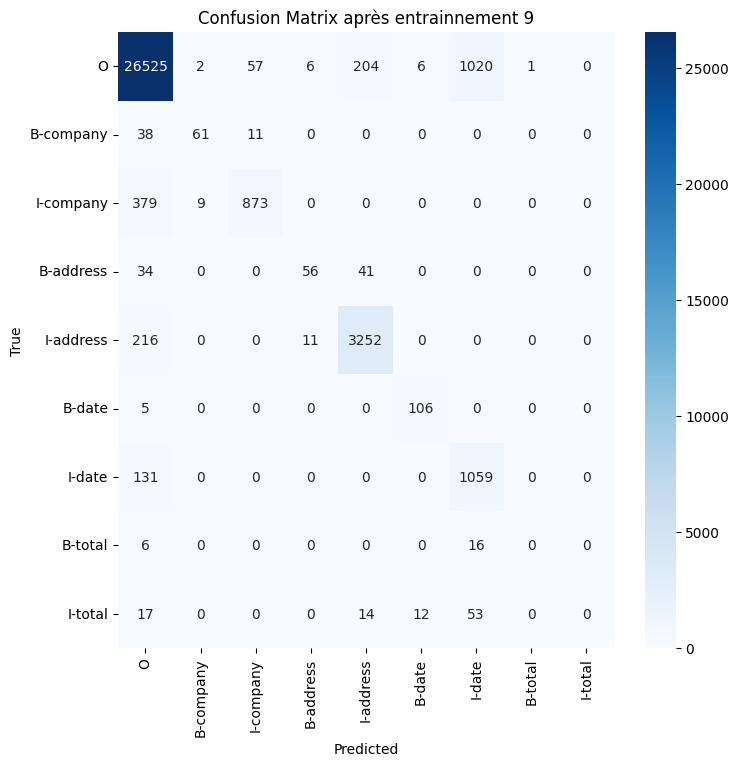

In [39]:
# Aplatir les listes
true_labels = []
pred_labels = []
for i, label in enumerate(labels):
    for j, label_id in enumerate(label):
        if label_id != -100:  # Ignorer les tokens spéciaux
            true_labels.append(label_id)
            pred_labels.append(predictions[i][j])

# Convertir les indices en étiquettes textuelles (selon votre mapping d'indices)
# Vous devez définir `id2label` basé sur votre modèle ou votre Tokenizer
true_label_text = [id2label[id] for id in true_labels]
pred_label_text = [id2label[id] for id in pred_labels]

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_label_text, pred_label_text, labels=list(id2label.values()))

# Sauvegarder le graphique Seaborn dans un fichier image (par exemple, PNG)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix après entrainnement 9')

## Loss and Accuracy

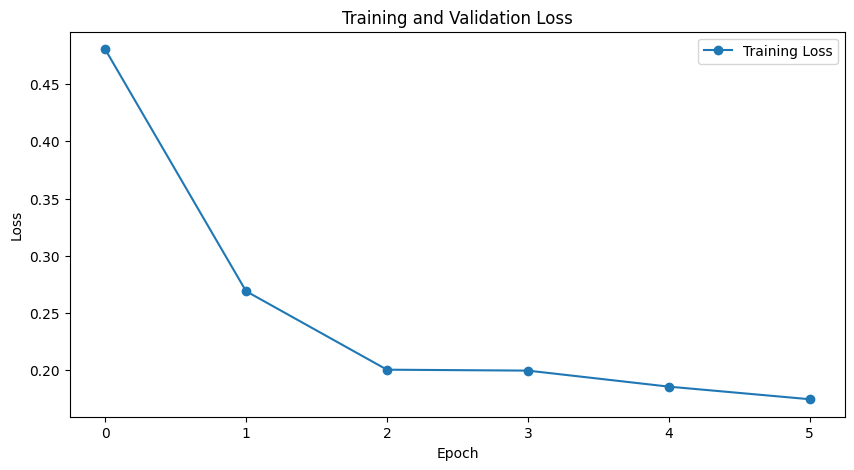

In [40]:
# Récupération des métriques d'entraînement
train_metrics = trainer.state.log_history

# Extraction des métriques spécifiques que vous souhaitez tracer (par exemple, la perte)
train_loss = [metric['loss'] for metric in train_metrics if 'loss' in metric]
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', marker='o')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
eval_losses = []
eval_accuracies = []

for log in trainer.state.log_history:
    if 'eval_loss' in log and 'step' in log:  # Métriques d'entraînement
        eval_losses.append(log['eval_loss'])
   
    if 'eval_accuracy' in log:  # Score F1 d'évaluation
        eval_accuracies.append(log['eval_accuracy'])

# Affichage des métriques récupérées
print("eval_losses", eval_losses)
print("eval_accuracies:", eval_accuracies)

eval_losses [0.2912714183330536, 0.19705525040626526, 0.20816993713378906, 0.1778768002986908, 0.16687718033790588, 0.16303814947605133]
eval_accuracies: [0.9272685948065231, 0.9417580544349111, 0.9391442695607705, 0.9504517302119438, 0.9539462469458492, 0.9577532814364452]


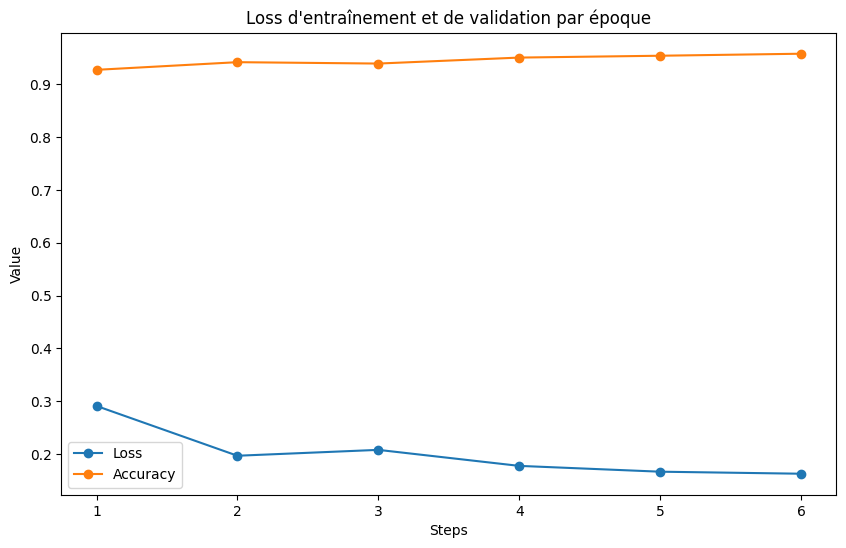

In [42]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

steps = range(1, len(eval_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(steps, eval_losses, label='Loss', marker='o')
plt.plot(steps, eval_accuracies, label='Accuracy', marker='o')
plt.title('Loss d\'entraînement et de validation par époque')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.legend()

# Configuration pour forcer l'axe des x à utiliser des entiers
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

# Save the model

In [48]:
saved_model_path='custom_model-9'
trainer.save_model(saved_model_path)

# Evaluate

In [49]:
predictions = trainer.predict(tokenized_datasets_eval)

In [50]:
from tabulate import tabulate

metrics = ['precision', 'recall', 'f1', 'accuracy']
prediction_results = []

for key, val in predictions.metrics.items():
    if any(item in key for item in metrics):
        prediction_results.append([key, str(round(val,4)*100)+'%'])

print(tabulate(prediction_results, headers=['Metric', 'Score']))

Metric          Score
--------------  ------------------
test_precision  56.21000000000001%
test_recall     82.85%
test_f1         66.97999999999999%
test_accuracy   93.91000000000001%


# Inference

In [51]:
inference= """MR. D.I.¥. (KUCHAT) SDN BHD
CO-REG:750441-W
LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :000473792512)
(TESCO EXTRA KAJANG)
-TAX INVOICE-

BOOSTER CABLE XH-500A +*§
CE72 - 10
9001620 1X 29.90 298,90
MOTH BALLS 1506 *§
EC21-41-71 - 10/100
9063977 1X 2,10 2,10
DIY GOLD TWIST DRILL 3MM *§
LB22 - 20/1500
9071246 1X 2,50 2,50
HSS TWIST DRILL 6*160MM *§
LG32-42 - 10/400
6909906163107 1X 3.30 3,30

Item(s) : 4 Qty(s) : 4
TOTAL INCL. GSTe6K RM 37.80
CASH RM 40.00
CHANGE RM 2.20

GST Summary Amt(RM) = Tax(RM)
GST S@6% 35.66 2.14

08-03-17 13:42 SHO1 BO28 = 12 000017473
OPERATOR TRAINEE

EXCHANGE ARE ALLOWED WITHIN
7 DAY WITH RECEIPT.
STRICTLY NO CASH REFUND.

 

ee are can"""

In [52]:
token_classifier = pipeline(
    "token-classification", model=saved_model_path, aggregation_strategy="simple"
)
results = token_classifier(inference)

In [53]:

prediction_results = []
for each_entity in results:
    prediction_results.append([each_entity['word'], each_entity['entity_group']])

print(tabulate(prediction_results, headers=['Word', 'Predictions']))

Word                                                                  Predictions
--------------------------------------------------------------------  -------------
I                                                                     address
LOT 1851                                                              address
A                                                                     address
1851                                                                  address
B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN  address
SELANG                                                                address
